In [ ]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [ ]:
# 1. Pass the image through selective search and generate region proposal.
# 2. Calculate IOU (intersection over union) on proposed region with ground truth data and add label to the proposed regions. (IoU = Area of the intersection / Area of the union..IoU > 0.5)
# 3. Do transfer learning using the proposed regions with the labels.
# 4. Pass the test image to selective search and then pass the first 2000 proposed regions from the trained model and predict the class of those regions.

In [ ]:
pip install opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation() #Pass the image through selective search and generate region proposal.

In [ ]:
# Initialize IOU

def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [ ]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Images.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
len(os.listdir('/tmp/Images/'))

733

In [ ]:
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Airplanes_Annotations.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
len(os.listdir('/tmp/Airplanes_Annotations/'))

733

In [ ]:
#Upload image files from local system
from google.colab import files
import cv2
import matplotlib.pyplot as plt

uploaded=files.upload()

Saving airplane_003.jpg to airplane_003.jpg


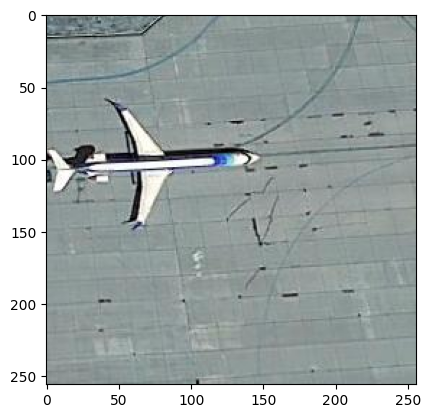

In [ ]:
img=cv2.imread('airplane_003.jpg')
plt.imshow(img)

In [ ]:
path = "/tmp/Images/"
annot = "/tmp/Airplanes_Annotations/"

In [ ]:
train_images=[]
train_labels=[]
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

1 airplane_322.jpg
2 airplane_339.jpg
3 airplane_208.jpg
4 airplane_167.jpg
5 airplane_022.jpg
6 airplane_451.jpg
7 airplane_515.jpg
8 airplane_069.jpg
9 airplane_649.jpg
10 airplane_340.jpg
11 airplane_685.jpg
12 airplane_019.jpg
13 airplane_205.jpg
14 airplane_443.jpg
15 airplane_436.jpg
16 airplane_114.jpg
17 airplane_284.jpg
18 airplane_048.jpg
19 airplane_358.jpg
20 airplane_686.jpg
21 airplane_326.jpg
inside
22 airplane_402.jpg
23 airplane_212.jpg
24 airplane_574.jpg
25 airplane_305.jpg
inside
26 airplane_337.jpg
27 airplane_123.jpg
inside
29 airplane_146.jpg
30 airplane_395.jpg
31 airplane_318.jpg
32 airplane_242.jpg
33 airplane_220.jpg
34 airplane_377.jpg
inside
35 airplane_540.jpg
36 airplane_601.jpg
37 airplane_199.jpg
inside
38 airplane_622.jpg
39 airplane_500.jpg
40 airplane_642.jpg
41 airplane_640.jpg
42 airplane_463.jpg
43 airplane_295.jpg
44 airplane_077.jpg
45 airplane_349.jpg
46 airplane_608.jpg
48 airplane_190.jpg
inside
49 airplane_580.jpg
50 airplane_165.jpg
51 airp

In [ ]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [ ]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
vggmodel = VGG16(weights='imagenet', include_top=True)

553467096/553467096 [==============================] - 11s 0us/step


In [ ]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False
X= vggmodel.layers[-2].output
predictions = Dense(2, activation="softmax")(X)
model_final = Model(Input=vggmodel.input, output = predictions)
opt = Adam(lr=0.0001)
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])
model_final.summary()

NameError: ignored